In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

DATA_GOLD = Path("../data/gold")
df = pd.read_parquet(DATA_GOLD / "train_features.parquet")

df.shape

(1017209, 33)

In [2]:
X = df.drop("Sales", axis=1).copy()
y = df["Sales"].copy()

# Remove leakage se existir
if "Customers" in X.columns:
    X = X.drop(columns=["Customers"])

# Date -> numérico (se ainda existir)
if "Date" in X.columns:
    X["Year"] = X["Date"].dt.year.astype("int16")
    X["Month"] = X["Date"].dt.month.astype("int8")
    X["Day"] = X["Date"].dt.day.astype("int8")
    X["WeekOfYear"] = X["Date"].dt.isocalendar().week.astype("int16")
    X["DayOfWeek_fromDate"] = X["Date"].dt.dayofweek.astype("int8")
    X = X.drop(columns=["Date"])

# One-hot + garantia numérica
obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
if obj_cols:
    X = pd.get_dummies(X, columns=obj_cols, drop_first=True)
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

mae, rmse

(480.6889618662812, 829.4284711040501)

Saved -> reports/figures/feature_importance_top20.png


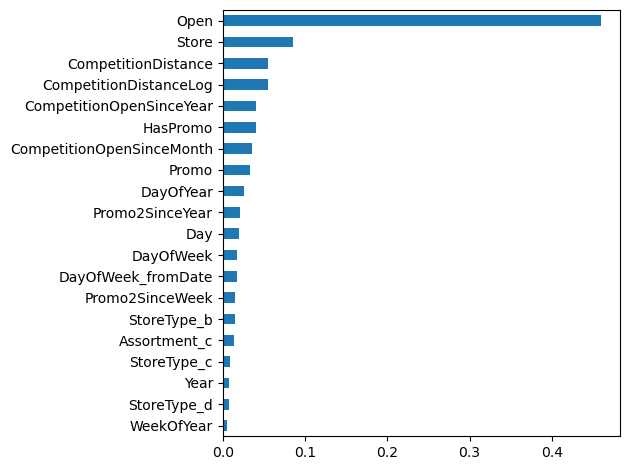

In [3]:
import matplotlib.pyplot as plt

Path("../reports/figures").mkdir(parents=True, exist_ok=True)

fi = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
ax = fi.head(20).sort_values().plot(kind="barh")
plt.tight_layout()
plt.savefig("../reports/figures/feature_importance_top20.png", dpi=150)
print("Saved -> reports/figures/feature_importance_top20.png")

In [4]:
import joblib
Path("../models").mkdir(parents=True, exist_ok=True)
joblib.dump(model, "../models/random_forest.joblib")
print("Saved -> models/random_forest.joblib")

Saved -> models/random_forest.joblib
